## Quantization aware (QKeras)Deep MLP for Jet-Images using jet constituents in HLS data
## Author: Andre Sznajder

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
#data_dir = '/Users/sznajder/cernbox/WorkM1/tensorflow_macos/arm64/workdir/data/hls4ml_LHCjet_30p_val/'

# Load HLS4ML dataset 

## Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

## https://github.com/pierinim/tutorials/blob/master/GGI_Jan2021/Lecture1/Notebook1_ExploreDataset.ipynb

 * 'jetImage' contains the image representation of the jets (more later)

 * 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)

 * 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored

 * 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList' 'jets' is the dataset we consider for the moment

 * 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'


In [3]:
import numpy as np
import h5py
import os

TRAIN_PATH = '/Users/sznajder/WorkM1/workdir/data/hls4ml_LHCjet_150p/'

# for pT, eta_rel, phi_rel
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
# for px, py, pz
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
#   myJetConstituentList = np.array(f.get("jetConstituentList"))
#
# Jet Constituents Features =  [0='j1_px', 1='j1_py', 2='j1_pz', 3='j1_e', 4='j1_erel', 5='j1_pt', 6='j1_ptrel',
#                         7='j1_eta', 8='j1_etarel', 9='j1_etarot', 10='j1_phi', 11='j1_phirel', 12='j1_phirot',
#                         13='j1_deltaR', 14='j1_costheta', 15='j1_costhetarel', 16='j1_pdgid']


# Prepare the DATA
#target = np.array([])
#jetConstituent = np.array([])
#jetImage = np.array([])
first=True
for file in os.listdir(TRAIN_PATH):
  print("Appending %s" %file)

  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
#        jetImage= data['jetImage'][:,:,:] 
        target = data['jets'][:,-6:-1]
    
        print("Keys in H5PY files = ",list( data.keys() ))
        print(" ")
        featurenames = data.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        # the b is due to the byte vs utf-8 encoding of the strings in the dataset
        # just ignore them for the moment
        print(" ")
        featurenames = data.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = data.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")

    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
         # Read (Pt,Eta,Phi)
#        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,7,10]] ] , axis=0 )
#        jetImage = np.concatenate( [ jetImage, data['jetImage']    ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )



                                    
print("Target shape =", target.shape)
print("Jet Constituents shape =", jetConstituent.shape)
print("Jet Constituents type =", type(jetConstituent))
#print("Jet Image shape =", jetImage.shape)



Appending jetImage_6_150p_40000_50000.h5
Keys in H5PY files =  ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
 
Jets Features =  [b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'

# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



In [4]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# The dataset is N_jets x N_particles x N_features
# the IN wants N_jets x N_features x N_particles
#jetList = np.swapaxes(jetList, 1, 2)

# The dataset is N_jets x N_phi x N_eta
# 3D tensor (tensorflow backend)
# 1st dim is jet image index
# 2nd dim is image eta bin
# 3rd dim is image phi bin
njet = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat = jetConstituent.shape[2]

print('Shape of jetConstituent =',jetConstituent.shape)
print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

print('Pt order of jetConstituent =',jetConstituent[0,:,0])

# Filter out constituents with Pt<2GeV
Ptmin =2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1


# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]
del constituents

# Restric the number of constituents to a maximum of NMAX
nmax = 8
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]

print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

# Shuffles jet constituents
print("Before --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])
for i in range(jetConstituent.shape[0]):
  jetConstituent[i] = jetConstituent[i, np.random.permutation(nconstit), :]
print("After --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])

# Flatten the 2D ( eta x phi ) jet image into 1D array to input into a MLP 
jetConstituent = rearrange( jetConstituent , 'batch njet nfeatures -> batch (njet nfeatures)' )  
print('Shape of flattened jetConstituent=',jetConstituent.shape)


Shape of jetConstituent = (880000, 150, 3)
Number of jets = 880000
Number of constituents = 150
Number of features = 3
Pt order of jetConstituent = [118.65740967 113.409935   113.00754547 104.92594147  61.50101852
  53.66347885  45.74335861  39.23477173  29.37190056  22.35709763
  21.92587852  17.52033234  17.42337799  15.18218422  14.11351871
  13.72482491  13.50632286  10.30114079   8.97198772   8.96437454
   8.07441998   7.58543396   7.50657463   7.46961069   6.23603106
   5.9958806    5.94867468   5.80270481   5.797472     5.78151035
   5.74027824   5.22847748   5.22158384   5.01134872   4.77666521
   4.57415247   4.06493235   4.00370693   3.98148799   3.89257169
   3.73196507   3.54980588   3.47391248   3.30842233   3.28169322
   3.13572168   3.02158785   2.85270143   2.67052031   2.46186328
   2.17798376   2.14579487   2.1329205    1.94092917   1.76847756
   1.68797469   1.18708348   1.16993809   1.11563432   1.10890877
   0.98700857   0.86270922   0.8541792    0.79871196   0.665

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [5]:
from sklearn.model_selection import train_test_split

X = jetConstituent
Y = target
del jetConstituent , target

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of Z jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))

print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of Z jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))


(589600, 24) (290400, 24) (589600, 5) (290400, 5)
number of G jets for training/validation: 118789
number of Q jets for training/validation: 114175
number of W jets for training/validation: 118845
number of Z jets for training/validation: 118615
number of T jets for training/validation: 119176
number of G jets for testing: 58463
number of Q jets for testing: 56504
number of W jets for testing: 58327
number of Z jets for testing: 58337
number of T jets for testing: 58769


## Define our Deep MLP model


In [6]:
# baseline keras model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras import utils

##################################
# Define execution ( CPU , GPU , any) 
# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
#from tensorflow.python.compiler.mlcompute import mlcompute
# Select CPU device.
#mlcompute.set_mlc_device(device_name='cpu') # Available options are 'cpu', 'gpu', and 'any'.

print('tensorflow version:',tf.__version__)
print('TF exceuting eagerly: ',tf.executing_eagerly())

##############################




#from qkeras.qlayers import QDense, QActivation , QBatchNormalization
#from qkeras.quantizers import quantized_bits, quantized_relu    
from qkeras import *


print("X type=",type(X_train_val))
print("X shape=",X_train_val.shape)

# Define MLP input layer dimension ( NINPUT = neta*nphi )
NINPUT = len(X_train_val[1])
NOUTPUT = len(Y_train_val[1])


print("NINPUT = ",NINPUT)
print("NOUTPUT = ",NOUTPUT)

'''
# MLP architechture for 32 contituents
nhidden1 = int(NINPUT/3.3)
nhidden2 = int(NINPUT/3.3)
nhidden3 = int(NINPUT/3.3)
'''

'''
# MLP architechture for 16 contituents
nhidden1 = int(NINPUT*0.8)
nhidden2 = int(NINPUT*0.8)
nhidden3 = int(NINPUT*0.8)
'''

#'''
# MLP architechture for 8 contituents
nhidden1 = int(NINPUT*1.75) 
nhidden2 = int(NINPUT*1.75) 
nhidden3 = int(NINPUT*1.75) 
#'''


#############################################################################


# Quantized bits
nbits=8
integ=0

#qbits = quantized_bits(nbits,integ,alpha=1.0)
#qact = 'quantized_relu('+str(nbits)+',0)'

# Set QKeras quantizer and activation 
if nbits == 1:
    qbits = 'binary(alpha=1)'
elif nbits == 2:
    qbits = 'ternary(alpha=1)'
else:
    qbits = 'quantized_bits({},0,alpha=1)'.format(nbits)

qact = 'quantized_relu({},0)'.format(nbits)



# Print
print("Trainign with max # of contituents = ", nconstit)
print("Number of node features = ", nfeat)
print("Quantization with nbits=",nbits)
print("Quantization of integer part=",integ)


#############################################################################


print("---------> Training with max # contituents=",nmax)




# Define the input tensor shape
inp  = Input(shape=(NINPUT,), name = 'inp') 

# Instantiate the MLP architechture 
h = BatchNormalization(name='batchnorm')(inp)

h = QDense( nhidden1, name = 'hidden1', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activation1')(h)

h = QDense( nhidden2, name = 'hidden2', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activation2')(h)

h = QDense( nhidden3, name='hidden3', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activation_dense3')(h)

out = QDense(NOUTPUT, name = 'denseout', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
out= Activation("softmax",name = 'activationOut')(out)


# create the model
model = Model(inputs=inp, outputs=out)
# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.01,decay=1e-6)
optim = Adam(learning_rate=0.0002)
#optim = Adam(learning_rate=0.0005)
#optim = Adam()

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# print the model summary
model.summary()

tensorflow version: 2.5.0
TF exceuting eagerly:  True
X type= <class 'numpy.ndarray'>
X shape= (589600, 24)
NINPUT =  24
NOUTPUT =  5
Trainign with max # of contituents =  8
Number of node features =  3
Quantization with nbits= 8
Quantization of integer part= 0
---------> Training with max # contituents= 8
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 24)]              0         
_________________________________________________________________
batchnorm (BatchNormalizatio (None, 24)                96        
_________________________________________________________________
hidden1 (QDense)             (None, 42)                1050      
_________________________________________________________________
activation1 (QActivation)    (None, 42)                0         
_________________________________________________________________
hidden2 (QDense) 

##### Run training
Here, we run the training.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('QMLP_model.h5', monitor='val_categorical_accuracy', 
                       verbose=0, save_best_only=True, 
                       save_weights_only=False, mode='auto', 
                       period=1)


# Train classifier
history = model.fit(  X_train_val, Y_train_val, 
                    epochs=300, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[lr, es, chkp], 
                    validation_split=0.3 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 

# Set NN and output name
arch = 'QMLP'
fname = arch+'_nconst_'+str(nmax)+'_nbits_'+str(nbits)
print('Saving Model : ',fname)


# Save the model
model.save('model_'+fname+'.h5')

## Save the model weights in a separate file
model.save_weights('weights_'+fname+'.h5')


Epoch 1/300
807/807 [==============================] - 2s 2ms/step - loss: 1.5082 - categorical_accuracy: 0.3372 - val_loss: 1.3956 - val_categorical_accuracy: 0.4198
Epoch 2/300
807/807 [==============================] - 1s 1ms/step - loss: 1.3418 - categorical_accuracy: 0.4442 - val_loss: 1.3055 - val_categorical_accuracy: 0.4598
Epoch 3/300
807/807 [==============================] - 1s 1ms/step - loss: 1.2776 - categorical_accuracy: 0.4694 - val_loss: 1.2569 - val_categorical_accuracy: 0.4796
Epoch 4/300
807/807 [==============================] - 1s 1ms/step - loss: 1.2374 - categorical_accuracy: 0.4885 - val_loss: 1.2232 - val_categorical_accuracy: 0.4984
Epoch 5/300
807/807 [==============================] - 1s 1ms/step - loss: 1.2091 - categorical_accuracy: 0.5036 - val_loss: 1.2002 - val_categorical_accuracy: 0.5100
Epoch 6/300
807/807 [==============================] - 1s 1ms/step - loss: 1.1893 - categorical_accuracy: 0.5136 - val_loss: 1.1847 - val_categorical_accuracy: 0.518

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))


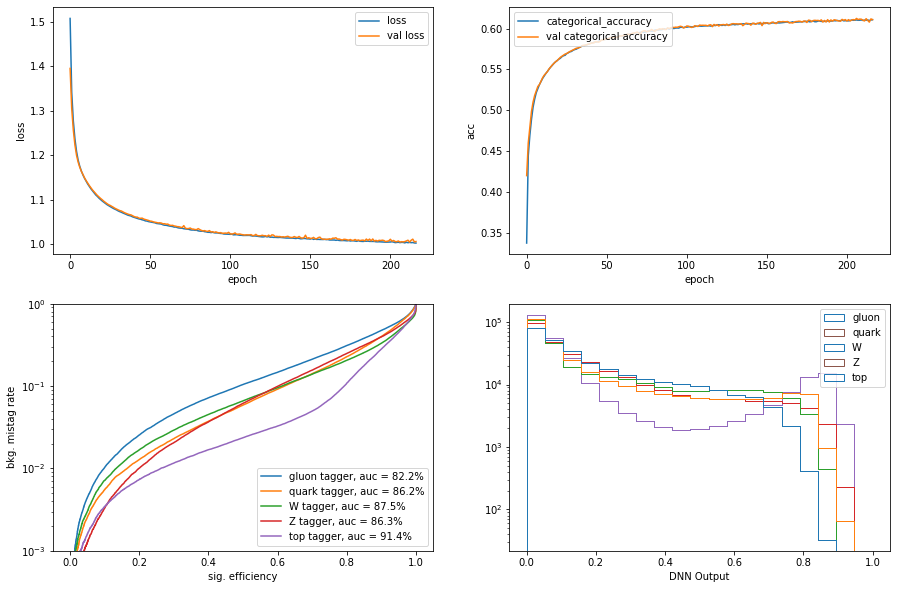

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}

# Model Prediction
Y_predict = model.predict(X_test)

# Loop over classes(labels) to get metrics per class and plots
ax = plt.subplot(2, 2, 3)
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))

   
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(loc='lower left')
ax.legend(prop={'size': 10})

# Display plots
fig = plt.gcf()
plt.show()


## Save information

In [9]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)


# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)



'''
# Save confusion matrix ndarrays to .npz file
with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
    vars = {}
    vars[arch]=np.array(1) # save model name
    for label in labels:
        vars['tresholds_'+label+'_'+arch] = tresholds[label]
        vars['TP_'+label+'_'+arch] = TP[label]
        vars['FP_'+label+'_'+arch] = FP[label]
        vars['TN_'+label+'_'+arch] = TN[label]
        vars['FN_'+label+'_'+arch] = FN[label]
        vars['TPR_'+arch] = tpr[label]
        vars['FPR_'+arch] = fpr[label]
        vars['NP_'+arch]= NP[label]
        vars['NN_'+arch]= NN[label]
        vars['auc_'+arch] = auc1[label] 
#        print(vars)
    np.savez(file, **vars)
'''


Label =  gluon  with treshold =  0.3
TPR =  0.3000017104835537
FPR =  0.046003871741033125
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000427620888425
FPR =  0.10458874608191017
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000273677368592
FPR =  0.3106619469942269
 
Label =  quark  with treshold =  0.3
TPR =  0.3000141582896786
FPR =  0.022993125149639155
 
Label =  quark  with treshold =  0.5
TPR =  0.5000353957241965
FPR =  0.058761158805623014
 
Label =  quark  with treshold =  0.8
TPR =  0.8000318561517769
FPR =  0.22734035639771522
 
Label =  W  with treshold =  0.3
TPR =  0.3000497196838514
FPR =  0.029150310462656148
 
Label =  W  with treshold =  0.5
TPR =  0.5000257170778541
FPR =  0.06614728986137983
 
Label =  W  with treshold =  0.8
TPR =  0.8000068578874278
FPR =  0.20556462837124526
 
Label =  Z  with treshold =  0.3
TPR =  0.3000668529406723
FPR =  0.020567690670205935
 
Label =  Z  with treshold =  0.5
TPR =  0.5000771380084681
FPR =  0.06180218302788467
 
Labe

"\n# Save confusion matrix ndarrays to .npz file\nwith open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:\n    vars = {}\n    vars[arch]=np.array(1) # save model name\n    for label in labels:\n        vars['tresholds_'+label+'_'+arch] = tresholds[label]\n        vars['TP_'+label+'_'+arch] = TP[label]\n        vars['FP_'+label+'_'+arch] = FP[label]\n        vars['TN_'+label+'_'+arch] = TN[label]\n        vars['FN_'+label+'_'+arch] = FN[label]\n        vars['TPR_'+arch] = tpr[label]\n        vars['FPR_'+arch] = fpr[label]\n        vars['NP_'+arch]= NP[label]\n        vars['NN_'+arch]= NN[label]\n        vars['auc_'+arch] = auc1[label] \n#        print(vars)\n    np.savez(file, **vars)\n"

In [10]:
from sklearn.metrics import accuracy_score

# Save a sample of events for Thea test on HLS

njets=3000
print(X_test.shape)
np.save('x_test_'+str(nconstit)+'const_QMLP.npy', X_test[0:njets,:])
np.save('y_test_'+str(nconstit)+'const_QMLP.npy', Y_test[0:njets,:])

'''
print(X_test.shape)
np.save('x_test_'+str(nconstit)+'const_full_QMLP.npy', X_test)
np.save('y_test_'+str(nconstit)+'const_full_QMLP.npy', Y_test)
'''

# Keras average accuracy to compare with 
y_keras = model.predict(X_test[0:njets,:])
accuracy_keras  = float(accuracy_score (np.argmax(Y_test[0:njets,:],axis=1), np.argmax(y_keras,axis=1)))
print("accuracy_keras = ",accuracy_keras)


(290400, 24)
accuracy_keras =  0.6193333333333333
